In [1]:
from one.api import ONE
import spikeglx
import numpy as np
from brainbox.io.one import SpikeSortingLoader
from neurodsp.voltage import destripe
import h5py

one = ONE()

pid = 'da8dfec1-d265-44e8-84ce-6ae9c109b8bd'
eid, probe = one.pid2eid(pid)

band = 'ap' # either 'ap','lf'

# Find the relevant datasets and download them
dsets = one.list_datasets(eid, collection=f'raw_ephys_data/{probe}', filename='*.lf.*')
data_files, _ = one.load_datasets(eid, dsets, download_only=True)
bin_file = next(df for df in data_files if df.suffix == '.cbin')

# Use spikeglx reader to read in the whole raw data
sr = spikeglx.Reader(bin_file)
sr.shape

# also get the spikes for this session
ssl = SpikeSortingLoader(pid=pid, one=one)
spikes, clusters, channels = ssl.load_spike_sorting(dataset_types=['spikes.samples'])
clusters = ssl.merge_clusters(spikes, clusters, channels)

c:\Users\Dan\.conda\envs\iblenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Dan\.conda\envs\iblenv\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Dan\.conda\envs\iblenv\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Downloading: D:\ONE\tmp3scxxww6\cache.zip Bytes: 94096227


100%|██████████| 89.73715496063232/89.73715496063232 [00:02<00:00, 34.43it/s]
100%|██████████| 10/10.0 [00:08<00:00,  1.16it/s]


In [33]:
# examine raw data

raw = sr[150000:151000, :-sr.nsync].T
raw = destripe(raw, fs=sr.fs)

In [3]:
import matplotlib.pyplot as plt

0.5126927083333334


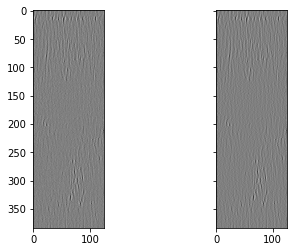

In [81]:
clipped = np.array(raw.copy())
clip_max = 4e-6
clipped[np.bitwise_and(clipped > -clip_max, clipped < 0)] = 0
clipped[np.bitwise_and(clipped < clip_max,clipped > 0)] = 0

range = 5e-5
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(clipped[:,0:125],cmap='gray', vmin=-range, vmax=range)
ax2.imshow(raw[:,0:125],cmap='gray', vmin=-range, vmax=range)

print(np.sum(clipped.flatten()==0) / len(clipped.flatten()))

In [82]:
min_vals = [1e-6, 2e-6, 3e-6, 4e-6, 5e-6]

for val in min_vals:
  clipped = np.array(raw.copy())
  clipped[np.bitwise_and(clipped > -val, clipped < val)] = 0
  clipped[clipped < -5e-5] = 0
  clipped[clipped > 5e-5] = 0
  perc = np.sum(clipped.flatten()==0) / len(clipped.flatten())
  print((val, perc))

(1e-06, 0.14139322916666666)
(2e-06, 0.27626822916666666)
(3e-06, 0.40143489583333336)
(4e-06, 0.5131536458333333)
(5e-06, 0.6097265625)


In [72]:
print(1e-1)

0.1


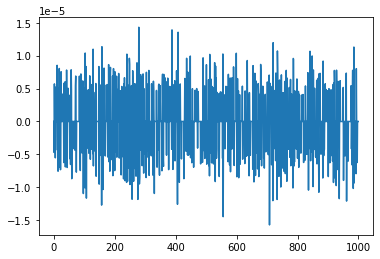

In [68]:
plt.plot(clipped[150,:])

(array([3.00000e+00, 1.40000e+01, 4.40000e+01, 2.30000e+02, 1.63900e+03,
        6.54590e+04, 3.07419e+05, 8.92000e+03, 2.50000e+02, 2.20000e+01]),
 array([-1.17045071e-04, -9.84331899e-05, -7.98213085e-05, -6.12094271e-05,
        -4.25975456e-05, -2.39856642e-05, -5.37378283e-06,  1.32380986e-05,
         3.18499800e-05,  5.04618614e-05,  6.90737428e-05]),
 <BarContainer object of 10 artists>)

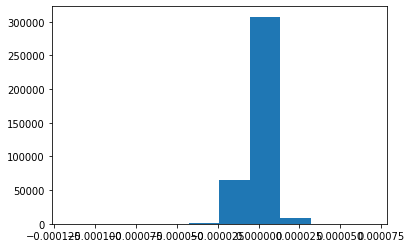

In [48]:
plt.hist(clipped.flatten())

In [28]:
import numpy as np

In [29]:
np.quantile(raw.flatten(),np.arange(0,1,0.1))

array([-1.17045071e-04, -7.74303854e-06, -4.79896064e-06, -2.87813052e-06,
       -1.31216611e-06,  1.26578351e-07,  1.55452758e-06,  3.10258662e-06,
        4.99236488e-06,  7.82884441e-06])

In [5]:

f.close()

In [6]:
# go through the raw data a little bit at a time and save it back out
f = h5py.File('./data.hdf5','w')
data = f.create_dataset('destriped', (sr.shape[0], sr.shape[1]-1))

In [7]:
sr.shape

(10739995, 385)

In [11]:
for i in np.arange(0,sr.shape[0], 10000):
    start = i
    stop = i + 99999

    raw = sr[start:stop, :-sr.nsync].T
    data[start:stop,:] = destripe(raw, fs=sr.fs).T

KeyboardInterrupt: 